In [1]:
import cv2
import import_ipynb
import numpy as np
import math
%matplotlib inline

from settings import *

from utils.models.ocr import load_model as load_ocr_model
from utils.models.yolo import load_model as load_yolo_model
from utils.general import clean_session
from utils.models.ocr import predict
from utils.images import show_image,show_bgr_image, dilate_image, label_components, filter_components, get_bounding_boxes, scale_bounding_boxes, prepare_img_for_prediction, visualize_bounding_boxes, get_components_mask, plot_images, get_angle_of_rotation, get_gradient, get_bottom_right_char, get_top_left_char, rotate_image, create_flow_chart


2024-03-25 10:35:19.271978: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 10:35:20.205563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 10:35:20.206416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 10:35:20.302695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 10:35:20.533927: I tensorflow/core/platform/cpu_feature_guar

In [5]:
yolo_model = load_yolo_model()
# ocr_model1 = load_ocr_model(version=1)
# ocr_model2 = load_ocr_model(version=2)
ocr_model3 = load_ocr_model(version=3)
# ocr_model4 = load_ocr_model(version=4)

ALL_OCR_MODELS = {3:ocr_model3}

Loaded model v3 from disk


In [ ]:
# TEST_IMAGES = f"{YOLO_DATASETS_DIR}/License-Plate-Dataset/test/images"
TEST_IMAGES = ["test_images/OCR/showcase/test_big.jpg","test_images/OCR/showcase/clever.jpg", "test_images/OCR/showcase/philippos.jpg"]
TEST_IMAGES = [TEST_IMAGES[1]]

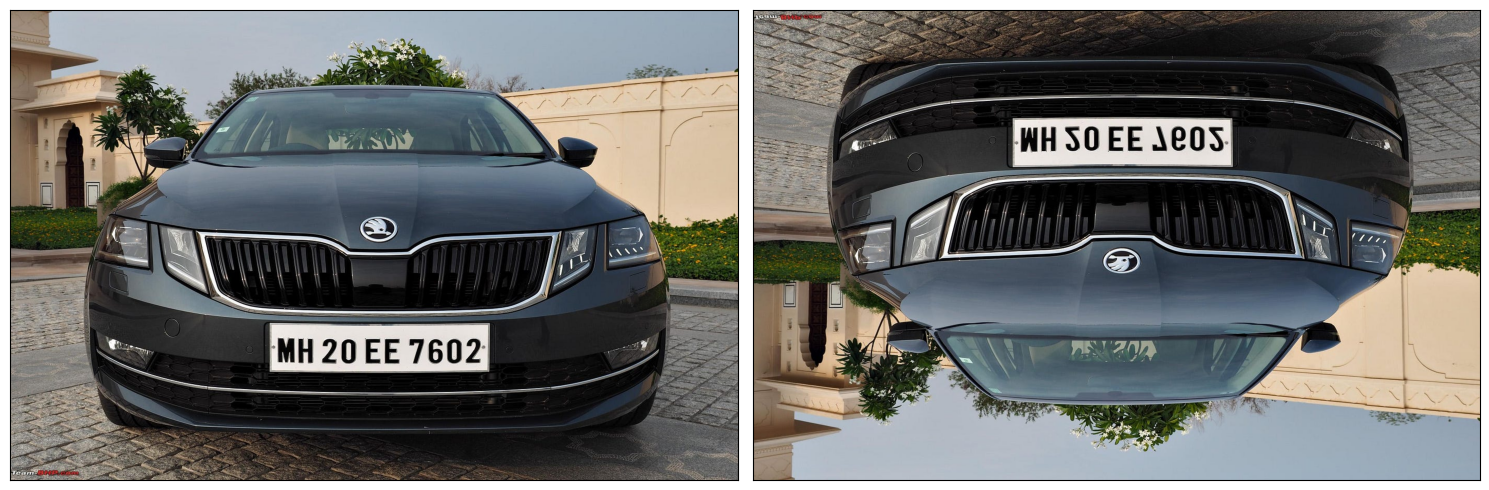


0: 448x640 1 License_Plate, 779.7ms
Speed: 84.5ms preprocess, 779.7ms inference, 63.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 License_Plate, 22.7ms
Speed: 19.0ms preprocess, 22.7ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)


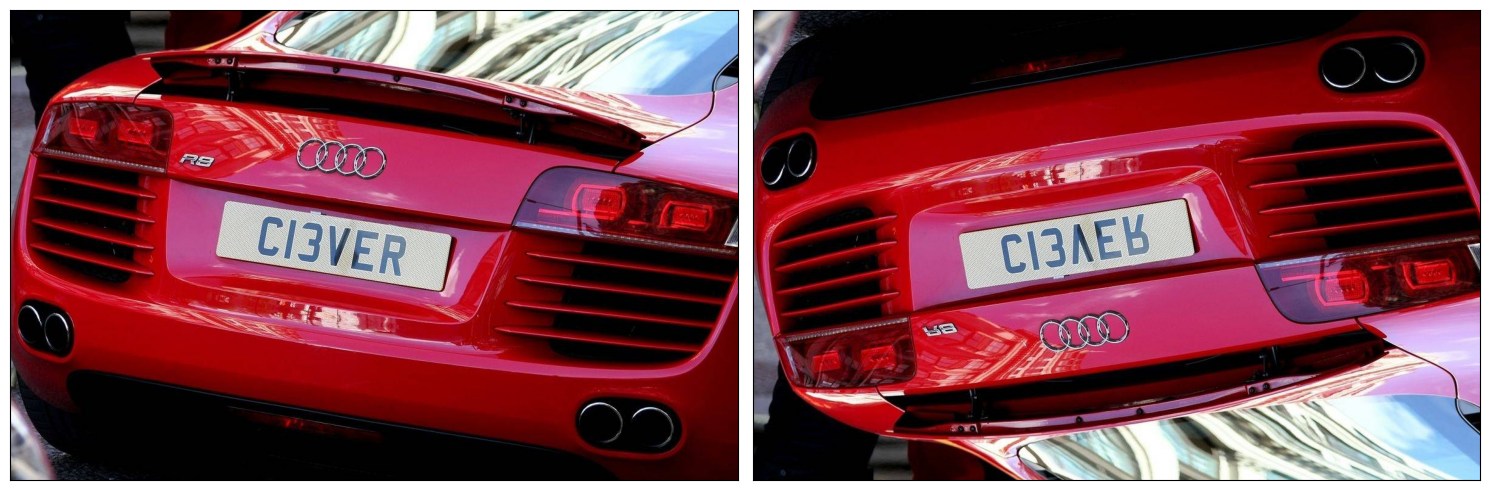


0: 416x640 1 License_Plate, 834.6ms
Speed: 14.1ms preprocess, 834.6ms inference, 7.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 License_Plate, 39.4ms
Speed: 15.8ms preprocess, 39.4ms inference, 8.5ms postprocess per image at shape (1, 3, 416, 640)


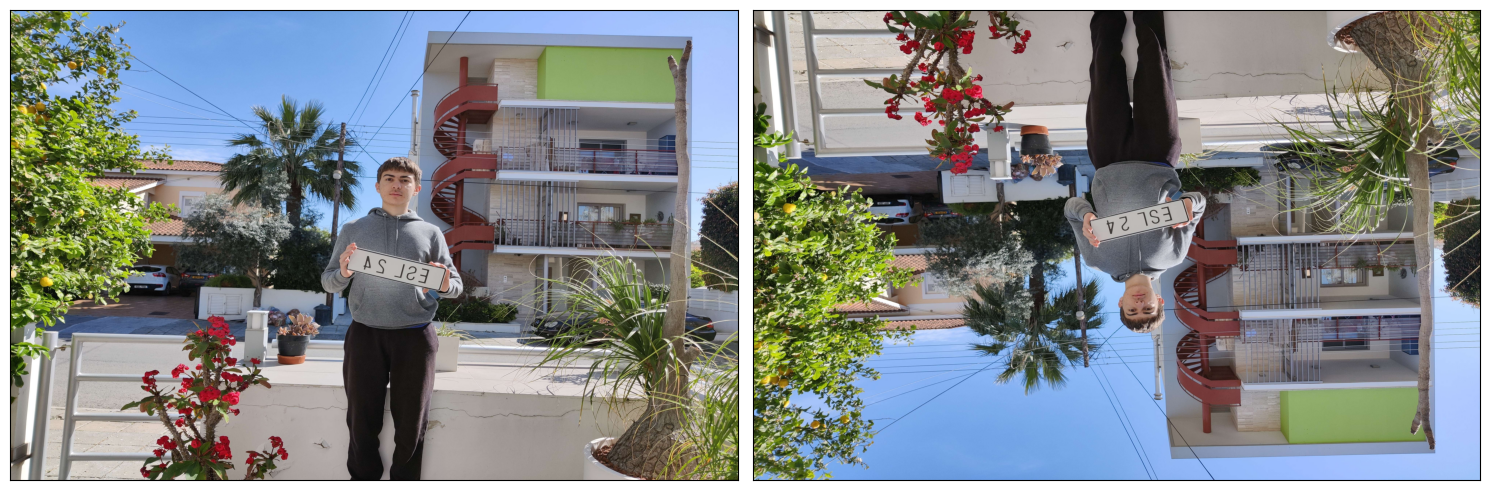


0: 480x640 (no detections), 717.5ms
Speed: 25.6ms preprocess, 717.5ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 31.3ms
Speed: 17.8ms preprocess, 31.3ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
# YOLO

all_results = []
for img_path in TEST_IMAGES:
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    hor_flip = cv2.flip(image, 1)
   # ver_flip = cv2.flip(image, 0)

    plot_images([image, hor_flip], cmap=None, figsize=(15, 5))
    image_results = []

    for flip_image in [image, hor_flip]:
        image_results.append((flip_image, yolo_model(flip_image)))
    all_results.append(image_results)

In [ ]:
def detect(license_plate_result, image, rotate=False):
    print(f"Found {len(license_plate_result.boxes)} plates")
    for box in license_plate_result.boxes:
        x1, y1, x2, y2 = map(int, box.cpu().data.numpy()[0][:4])
        print(f"Coordinates: {x1, y1, x2, y2}")

        cropped_image = image[y1:y2, x1:x2]
        show_image(cropped_image, "Cropped image")


        area = (x2 - x1) * (y2 - y1)
        original_area = image.shape[0] * image.shape[1]
        original_area_ratio = area / original_area
        print(f"Original area ratio: {original_area_ratio}")
        K = 1
        padding_number = int(K / original_area_ratio)
        print(f"Padding: {padding_number}")

        padded_image = cv2.copyMakeBorder(cropped_image, padding_number, padding_number, padding_number, padding_number, cv2.BORDER_CONSTANT, value=0)
        color_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2BGR)
        show_image(padded_image, "Padded image")
        padded_area = padded_image.shape[0] * padded_image.shape[1]
        padded_area_ratio = area / padded_area

        processed_image = dilate_image(padded_image)
        show_image(processed_image, "Processed image")

        labels = label_components(processed_image)

        # lower and upper bound must also be proportional to the padding_number
        # Set lower bound and upper bound criteria for characters
        lower = (padded_area // 90) * padded_area_ratio # TODO: TUNE
        upper = (padded_area // 10) * padded_area_ratio # TODO: TUNE

        components = filter_components(labels, lower, upper)

        mask = get_components_mask(padded_image, components)

        bounding_boxes = get_bounding_boxes(mask)
        print(f"Detected {len(bounding_boxes)} characters")

        if rotate:
            top_left = get_top_left_char(bounding_boxes)
            bottom_right = get_bottom_right_char(bounding_boxes, top_left, top_left[3])
            try:
                gradient = get_gradient(top_left, bottom_right)
            except ZeroDivisionError:
                print("Division by zero when finding gradient, not rotating!")
                return image
            angle_of_rot  = get_angle_of_rotation(gradient)
            print(f"Angle of rotation: {angle_of_rot} degrees")

            rotated_image = rotate_image(image, angle_of_rot)

            return rotated_image
        else:


            # scale the bounding boxes to all be at least as big as the average but keep the character(previous bounding box) centered and increase the whole box by some factor to avoid cutting the characters

            avg_char_size = np.mean([box[2] * box[3] for box in bounding_boxes])
            char_to_img_ratio = avg_char_size / padded_area
            K = 60
            char_scale = K * char_to_img_ratio
            print(f"Average character size: {avg_char_size} Char to image ratio: {char_to_img_ratio} Char scale: {char_scale}")

            bounding_boxes = scale_bounding_boxes(bounding_boxes, factor_x=char_scale, factor_y=char_scale)

            predictions = []
            for i, box in enumerate(bounding_boxes):
                # top left x,y
                x, y, w, h = box
                roi = mask[y:y+h, x:x+w]
                # show_image(roi, f"ROI {i}")
                char = prepare_img_for_prediction(roi)
                show_image(char, f"Character {i}")
                prediction = {version:predict(ocr_model, char) for version, ocr_model in ALL_OCR_MODELS.items()}
                # pprint(f"Prediction for character {i}: {prediction}")
                predictions.append(prediction)

            roi_area = w * h
            K = 70
            K2 = 25
            font_scale = math.sqrt(roi_area) / K
            border_size = max(1, math.sqrt(roi_area) // K2)
            print(f"Font scale: {font_scale} border_size: {border_size}")

            results_images = []

            for version in ALL_OCR_MODELS.keys():
                license_plate = "".join([prediction[version][0] for prediction in predictions])
                result_image = visualize_bounding_boxes(color_image, bounding_boxes, license_plate, font_scale, border_size)
                results_images.append(result_image)
                show_bgr_image(result_image, f"Model {version} detections")
                print(f"License plate: {license_plate}")

                overall_confidence = np.mean([prediction[version][1][0][1] for prediction in predictions])

                print(f"Overall confidence: {overall_confidence}")

    return overall_confidence, [cropped_image, padded_image, processed_image, result_image]

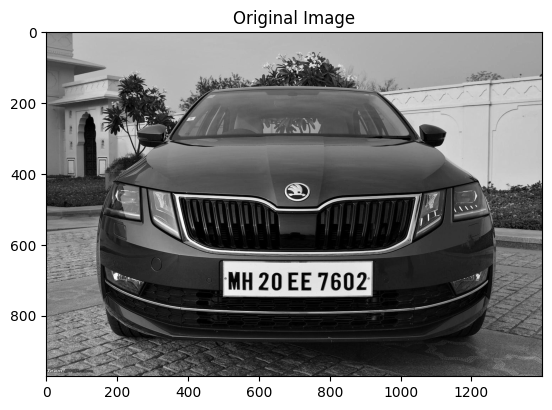

Found 1 plates
Coordinates: (494, 646, 928, 744)


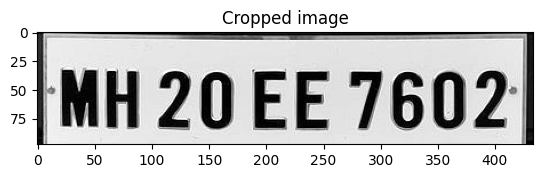

Original area ratio: 0.03125514403292181
Padding: 31


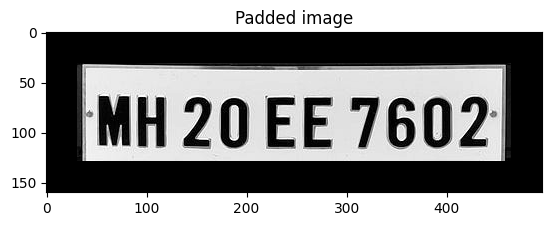

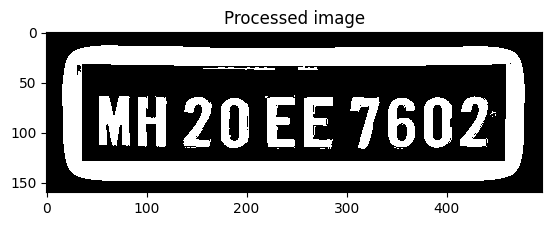

Detected 10 characters
Finding the gradient between (53, 64, 31, 50) and (414, 64, 28, 51)
Angle of rotation: 0.0 degrees


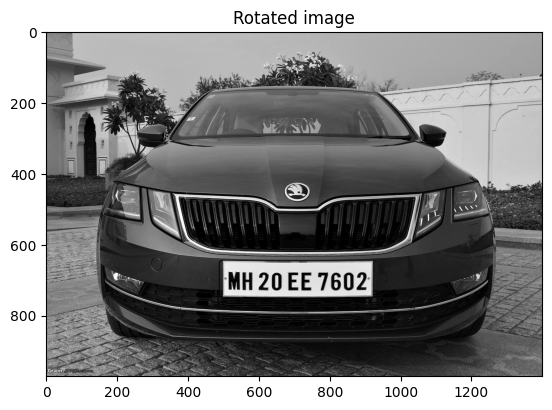


0: 448x640 1 License_Plate, 63.0ms
Speed: 17.4ms preprocess, 63.0ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)
Found 1 plates
Coordinates: (494, 646, 928, 744)


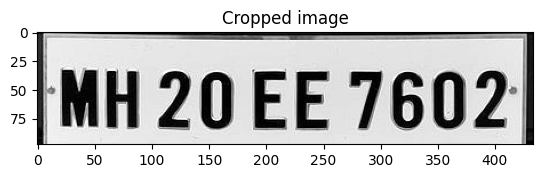

Original area ratio: 0.03125514403292181
Padding: 31


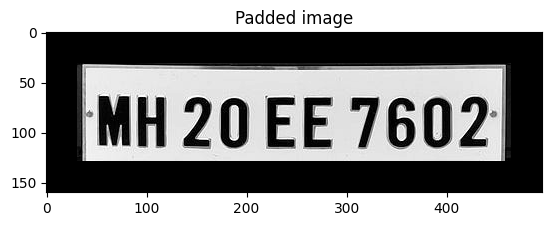

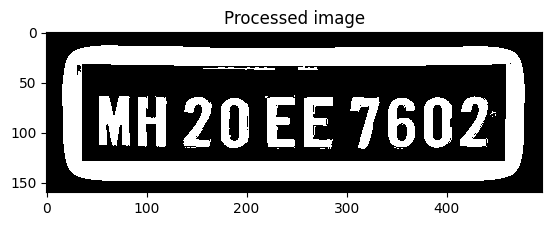

Detected 10 characters
Average character size: 1474.2 Char to image ratio: 0.018576108870967743 Char scale: 1.1145665322580647
Average width: 28, Average height: 51


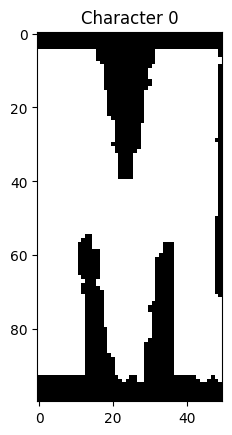

2024-03-25 10:39:19.803208: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-25 10:39:19.923371: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-25 10:39:21.474803: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


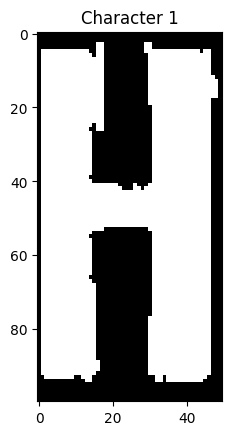

1/1 [==============================] - 0s 176ms/step


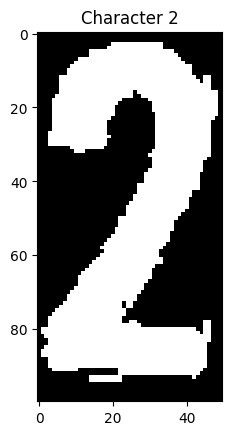

1/1 [==============================] - 0s 198ms/step


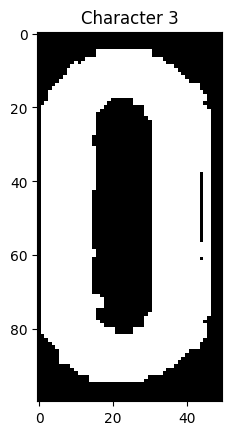

1/1 [==============================] - 0s 181ms/step


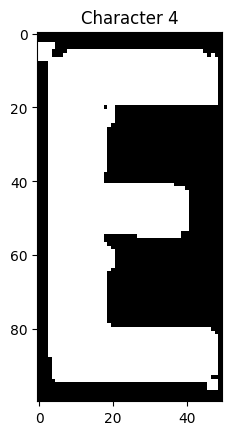

1/1 [==============================] - 0s 133ms/step


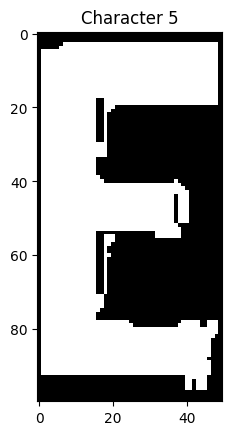

1/1 [==============================] - 0s 161ms/step


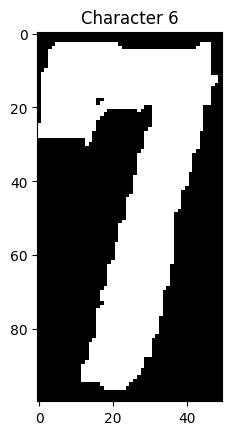

1/1 [==============================] - 0s 133ms/step


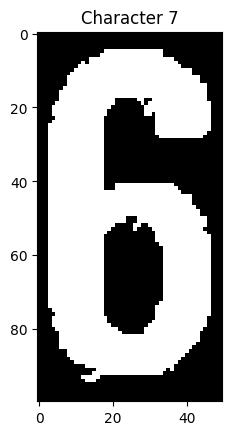

1/1 [==============================] - 0s 122ms/step


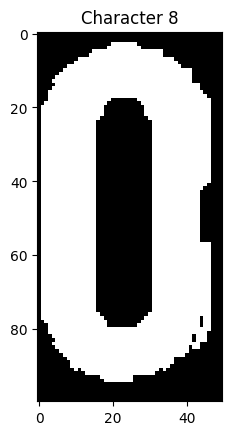

1/1 [==============================] - 0s 198ms/step


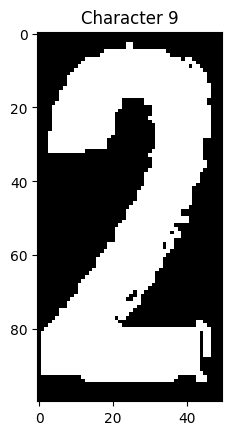

1/1 [==============================] - 0s 145ms/step
Font scale: 0.595219047314276 border_size: 1


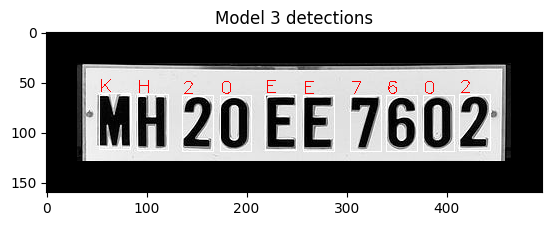

License plate: KH20EE7602
Overall confidence: 0.8522816002368927


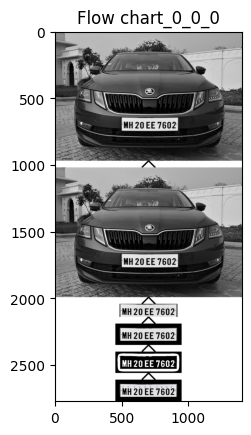

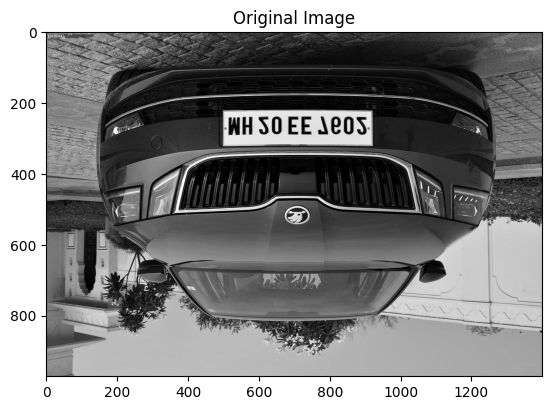

Found 1 plates
Coordinates: (489, 210, 930, 310)


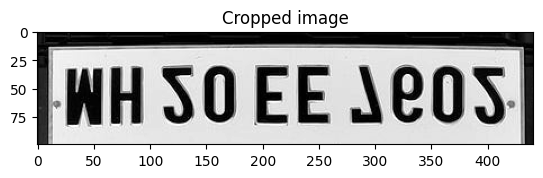

Original area ratio: 0.032407407407407406
Padding: 30


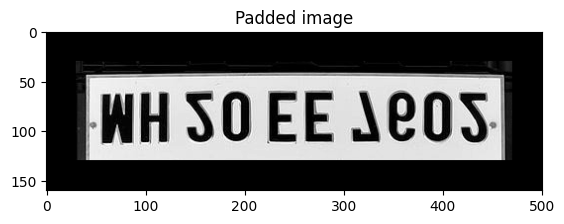

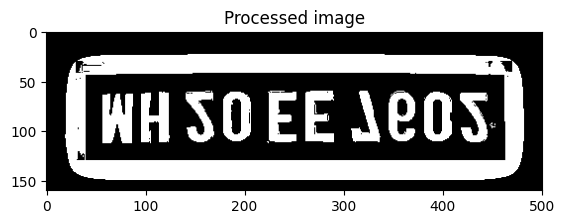

Detected 10 characters
Finding the gradient between (57, 63, 31, 50) and (418, 62, 28, 50)
Angle of rotation: -0.1587136647184726 degrees


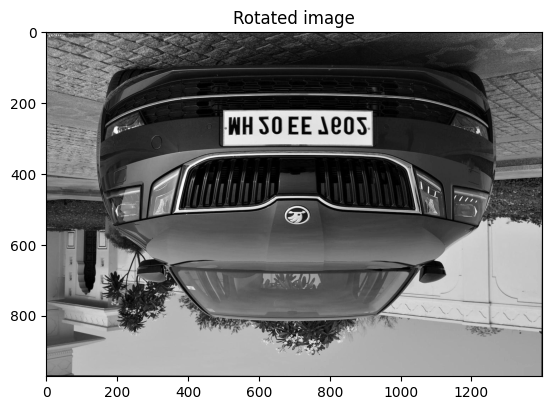


0: 448x640 1 License_Plate, 177.9ms
Speed: 46.1ms preprocess, 177.9ms inference, 62.2ms postprocess per image at shape (1, 3, 448, 640)
Found 1 plates
Coordinates: (492, 210, 931, 312)


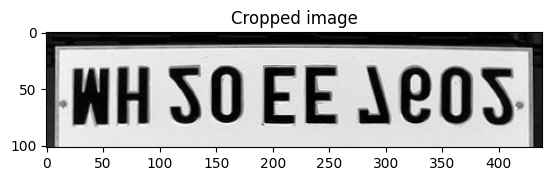

Original area ratio: 0.03290564373897707
Padding: 30


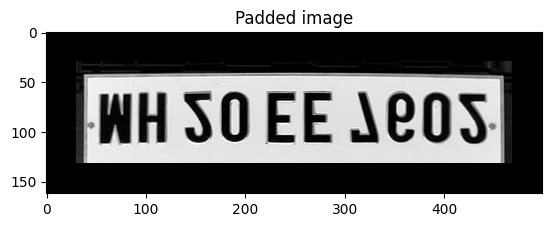

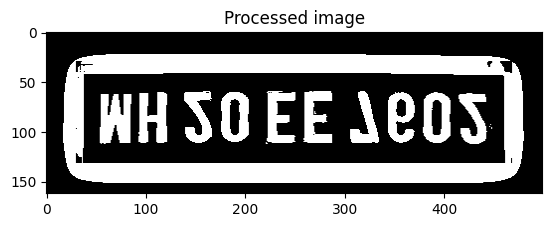

Detected 10 characters
Average character size: 1474.3 Char to image ratio: 0.018237709987876986 Char scale: 1.0942625992726192
Average width: 28, Average height: 51


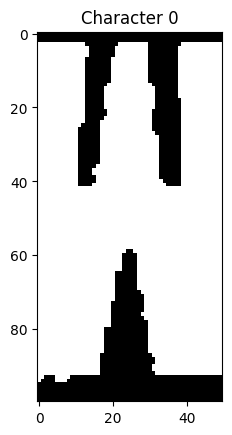

1/1 [==============================] - 0s 121ms/step


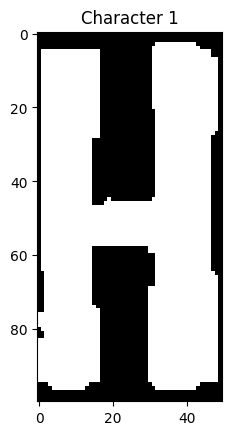

1/1 [==============================] - 0s 152ms/step


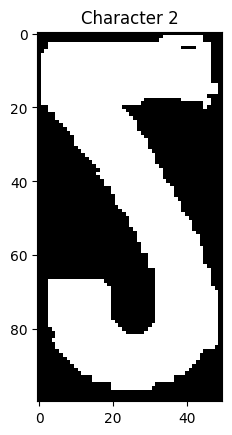

1/1 [==============================] - 0s 168ms/step


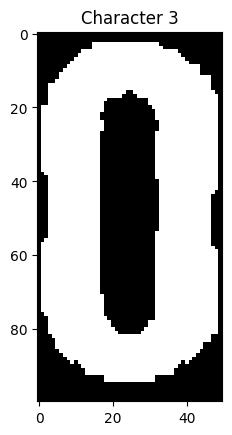

1/1 [==============================] - 0s 171ms/step


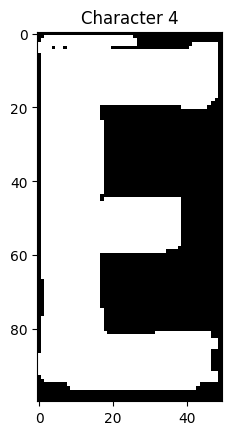

1/1 [==============================] - 0s 149ms/step


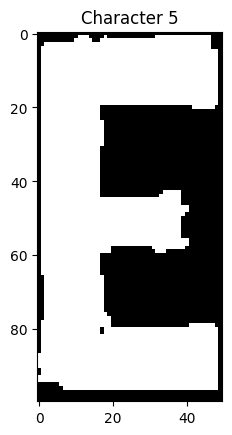

1/1 [==============================] - 0s 120ms/step


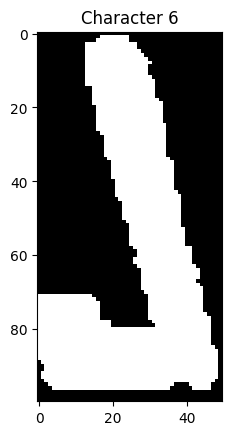

1/1 [==============================] - 0s 121ms/step


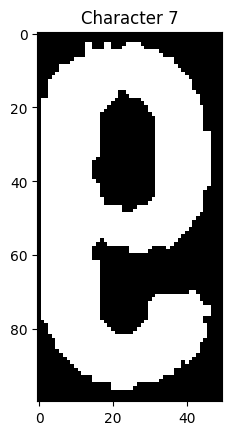

1/1 [==============================] - 0s 158ms/step


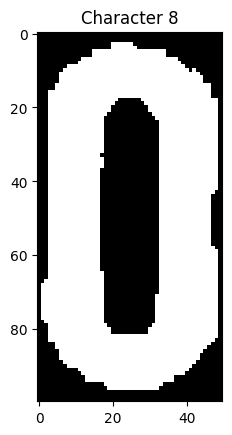

1/1 [==============================] - 0s 158ms/step


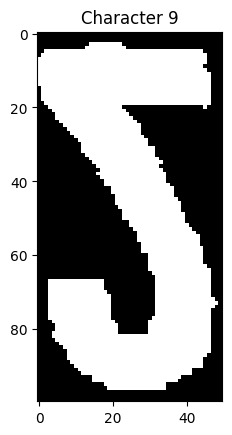

1/1 [==============================] - 0s 147ms/step
Font scale: 0.5802884574739972 border_size: 1


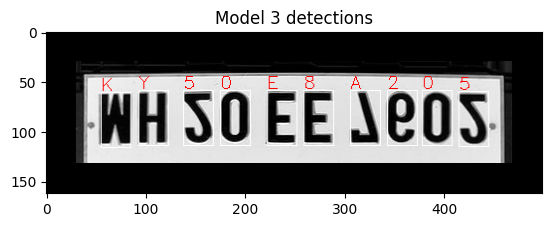

License plate: KY50E8A205
Overall confidence: 0.6921749889850617


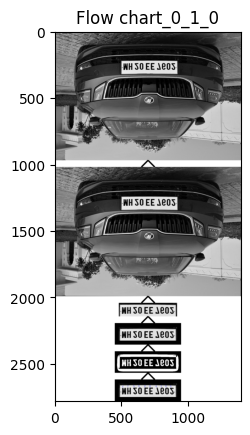

Confidences: [0.6921749889850617]
Highest confidence: 0.6921749889850617
Highest confidence index: 0


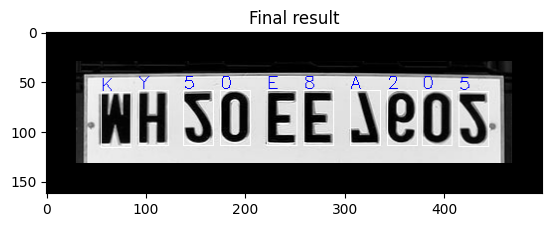

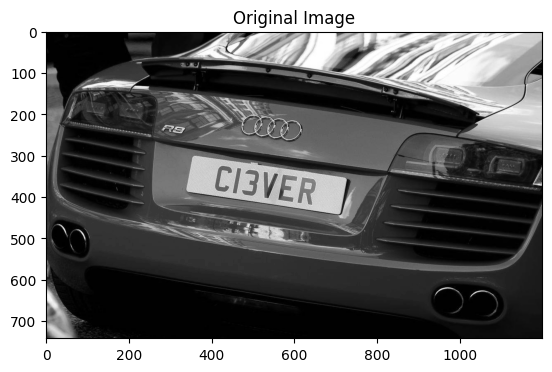

Found 1 plates
Coordinates: (358, 295, 722, 436)


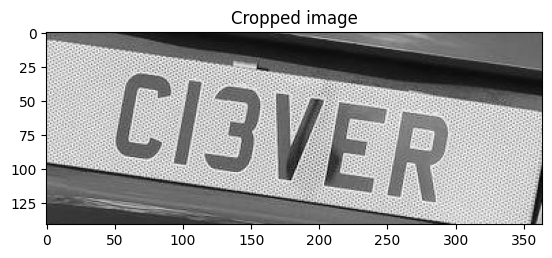

Original area ratio: 0.05764150943396226
Padding: 17


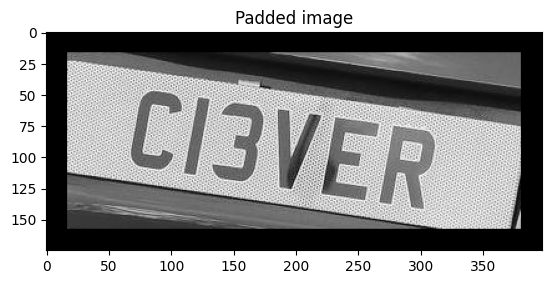

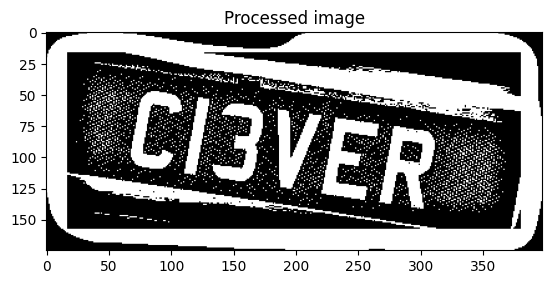

Detected 6 characters
Finding the gradient between (68, 48, 41, 62) and (267, 76, 45, 66)
Angle of rotation: 8.009140297037225 degrees


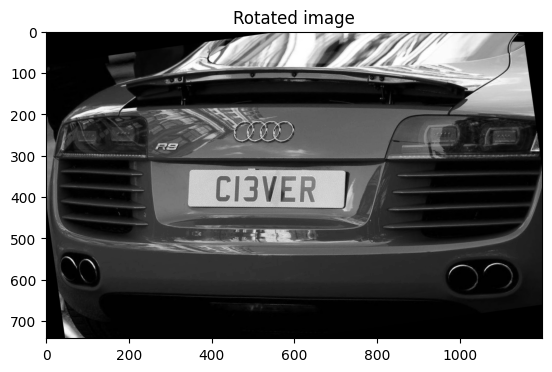


0: 416x640 1 License_Plate, 53.6ms
Speed: 14.2ms preprocess, 53.6ms inference, 6.8ms postprocess per image at shape (1, 3, 416, 640)
Found 1 plates
Coordinates: (356, 332, 723, 423)


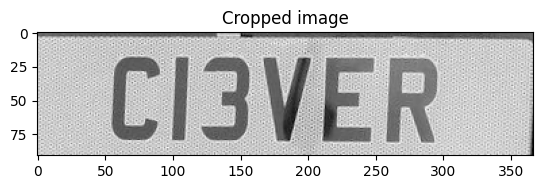

Original area ratio: 0.03750786163522012
Padding: 26


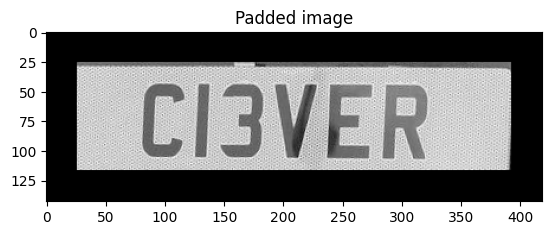

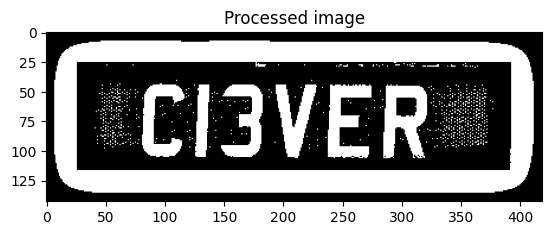

Detected 6 characters
Average character size: 1976.1666666666667 Char to image ratio: 0.03298173584569766 Char scale: 1.9789041507418599
Average width: 32, Average height: 61


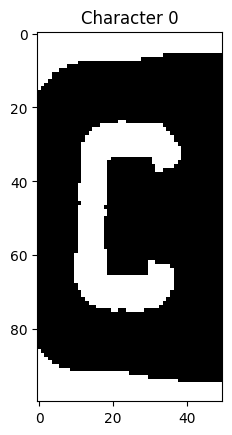

1/1 [==============================] - 0s 167ms/step


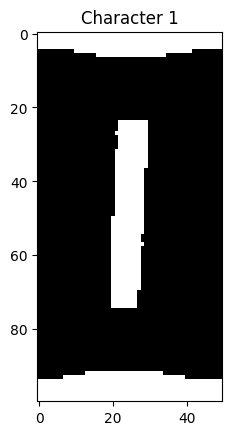

1/1 [==============================] - 0s 146ms/step


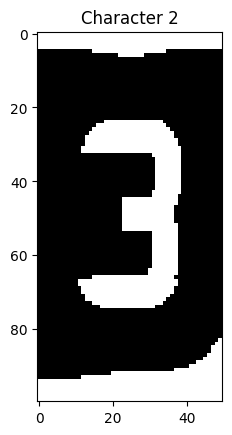

1/1 [==============================] - 0s 118ms/step


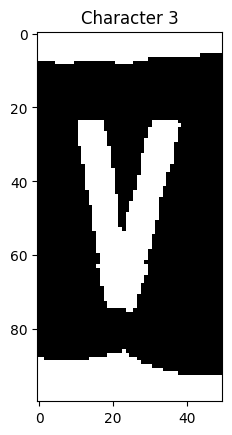

1/1 [==============================] - 0s 136ms/step


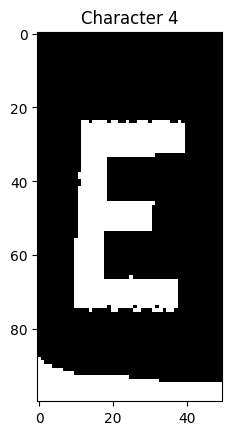

1/1 [==============================] - 0s 133ms/step


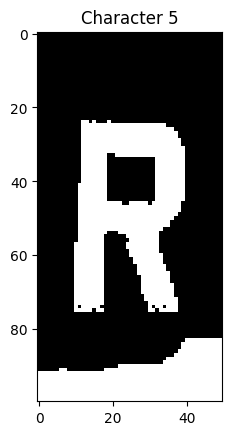

1/1 [==============================] - 0s 164ms/step
Font scale: 1.2421180068162376 border_size: 3.0


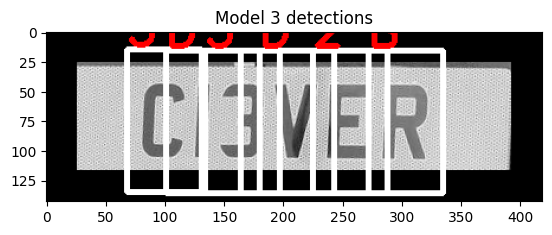

License plate: 3D5D2B
Overall confidence: 0.6997077862421671


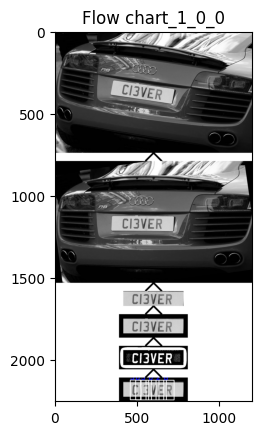

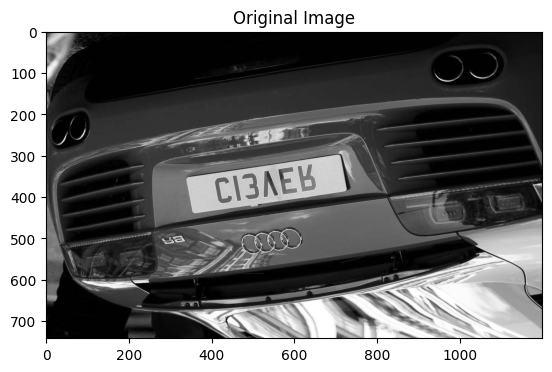

Found 1 plates
Coordinates: (339, 290, 727, 422)


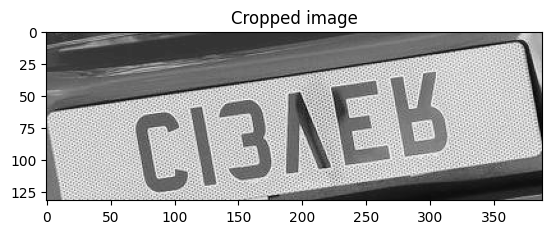

Original area ratio: 0.05752021563342318
Padding: 17


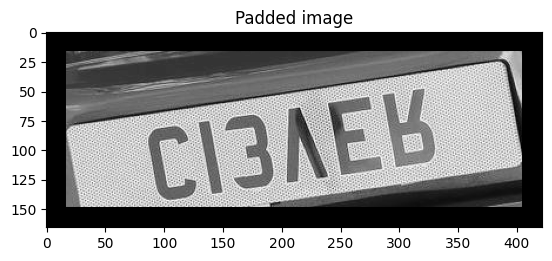

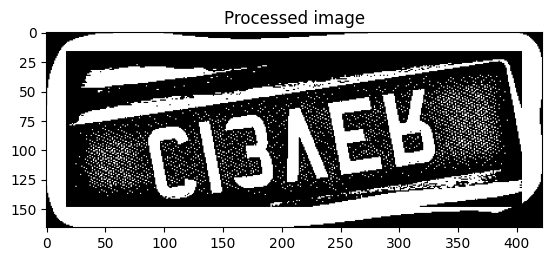

Detected 7 characters
Finding the gradient between (30, 30, 128, 18) and (30, 30, 128, 18)
Division by zero when finding gradient, not rotating!


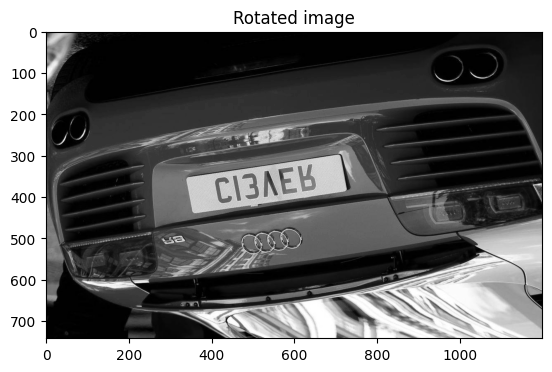


0: 416x640 1 License_Plate, 121.9ms
Speed: 29.2ms preprocess, 121.9ms inference, 42.3ms postprocess per image at shape (1, 3, 416, 640)
Found 1 plates
Coordinates: (297, 294, 743, 432)


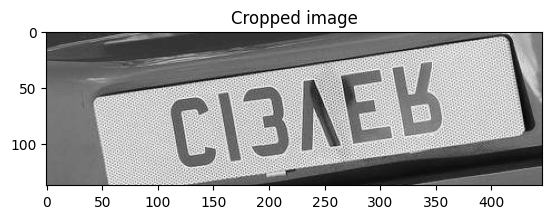

Original area ratio: 0.06912398921832884
Padding: 14


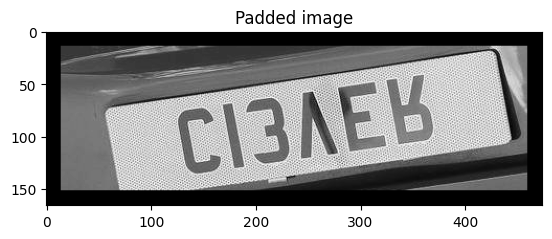

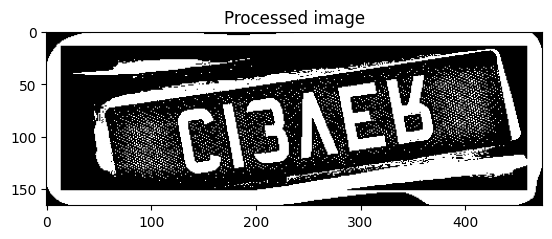

Detected 7 characters
Average character size: 9213.57142857143 Char to image ratio: 0.11709586991728216 Char scale: 7.0257521950369295
Average width: 109, Average height: 65


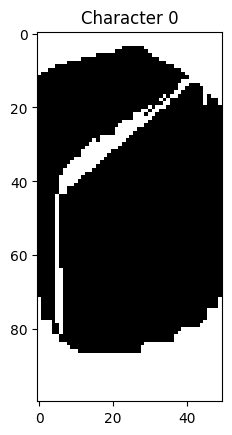

1/1 [==============================] - 0s 152ms/step


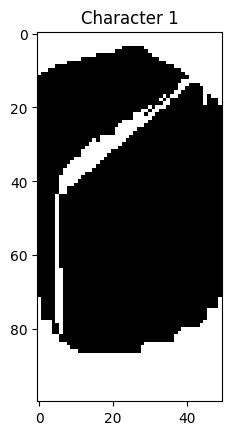

1/1 [==============================] - 0s 128ms/step


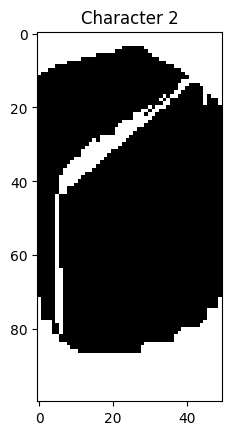

1/1 [==============================] - 0s 123ms/step


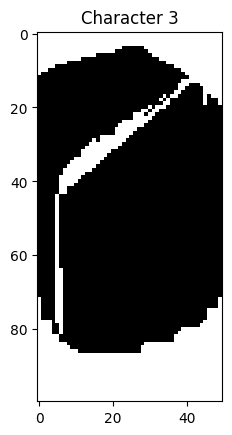

1/1 [==============================] - 0s 159ms/step


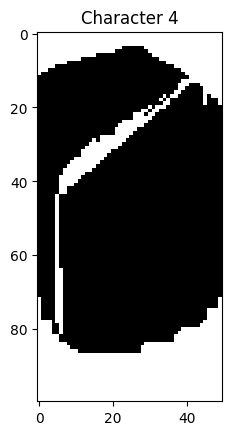

1/1 [==============================] - 0s 121ms/step


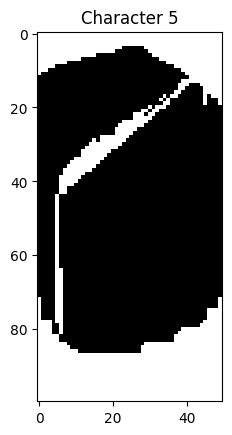

1/1 [==============================] - 0s 124ms/step


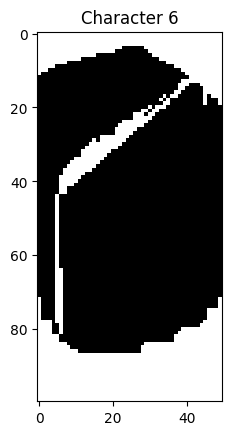

1/1 [==============================] - 0s 148ms/step
Font scale: 8.437525510165518 border_size: 23.0


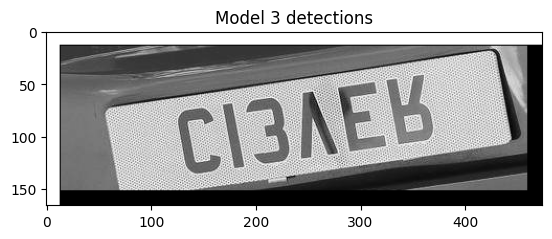

License plate: CCCCCCC
Overall confidence: 0.9334186315536499


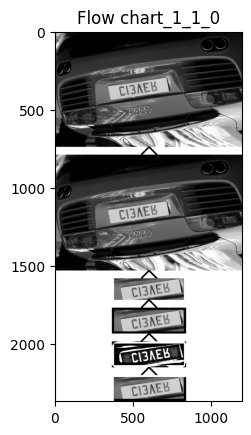

Confidences: [0.9334186315536499]
Highest confidence: 0.9334186315536499
Highest confidence index: 0


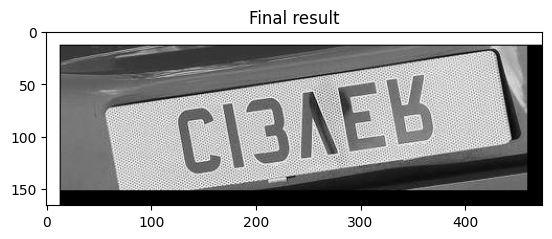

No license plates found
No license plates found
Confidences: [0.9334186315536499]
Highest confidence: 0.9334186315536499
Highest confidence index: 0


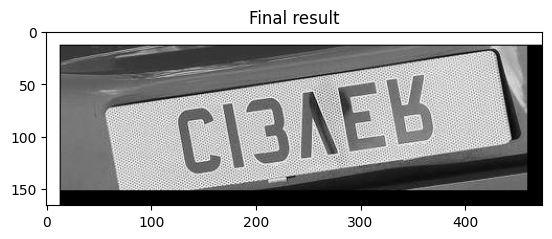

In [ ]:
for img_i, image_results in enumerate(all_results):
    for res_i, (flip_image, flip_results) in enumerate(image_results):
        image = cv2.cvtColor(flip_image, cv2.COLOR_BGR2GRAY)
        all_image_processes = [image]


        for license_i, license_plate_result in enumerate(flip_results):

            if len(license_plate_result.boxes) == 0:
                print("No license plates found")
                continue

            show_image(image, "Original Image")
            rotated_image = detect(license_plate_result, image, rotate=True)
            all_image_processes.append(rotated_image)
            show_image(rotated_image, "Rotated image")
            rotated_results = yolo_model(cv2.cvtColor(rotated_image, cv2.COLOR_GRAY2BGR))

            confidences = []
            result_images = []

            for license_plate_result in rotated_results:
                overall_confidence, resulting_images = detect(license_plate_result, rotated_image, rotate=False)
                all_image_processes.extend(resulting_images)
                confidences.append(overall_confidence)
                result_images.append(resulting_images[-1])

            # save a flow chart file showing every image from the original to the final result
            flow_chart = create_flow_chart(all_image_processes, save=True, output_path=f"{OCR_RESULTS_DIR}/flow_chart_{img_i}_{res_i}_{license_i}.png")
            show_image(flow_chart, f"Flow chart_{img_i}_{res_i}_{license_i}")

    if len(confidences) == 0:
        print("No license plates found in any of the translations")
        continue

    print(f"Confidences: {confidences}")
    highest_confidence = max(confidences)
    print(f"Highest confidence: {highest_confidence}")
    highest_confidence_index = confidences.index(highest_confidence)
    print(f"Highest confidence index: {highest_confidence_index}")
    show_image(result_images[highest_confidence_index], "Final result")
    # break